In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import time
torch.cuda.is_available()


False

# İs Cuda Available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def read_images(path,num_img):
    array = np.zeros([num_img,64*32])
    i = 0
    for image in os.listdir(path):
        img_path = path + "\\" + image
        if image.endswith(".png"):
            img = Image.open(img_path, mode="r")
            data = np.asarray(img, dtype="uint8")
            data = data.flatten()
            array[i,:] = data
            i += 1
        else:
            pass
    return array    

In [4]:
train_neg_path = r"C:\Users\mustdo\Desktop\workspace\Machine Learning\deeplearning\LSIFIR\Classification\Train\neg"
train_pos_path = r"C:\Users\mustdo\Desktop\workspace\Machine Learning\deeplearning\LSIFIR\Classification\Train\pos"

pos_nums = 10208
neg_nums = 43390

pos_train_array = read_images(train_pos_path,pos_nums)
neg_train_array = read_images(train_neg_path,neg_nums)

In [5]:
x_pos_train_tensor = torch.from_numpy(pos_train_array)

y_pos_train_tensor =torch.ones(pos_nums,dtype=torch.long)

print(y_pos_train_tensor.size())

x_neg_train_tensor = torch.from_numpy(neg_train_array)

y_neg_train_tensor =torch.zeros(neg_nums,dtype=torch.long)

print(y_neg_train_tensor.size())


torch.Size([10208])
torch.Size([43390])


In [6]:
x_train = torch.cat((x_neg_train_tensor,x_pos_train_tensor),0)
y_train = torch.cat((y_neg_train_tensor,y_pos_train_tensor),0)
print(x_train.size())

print(y_train.size())

torch.Size([53598, 2048])
torch.Size([53598])


In [7]:
test_neg_path = r"C:\Users\mustdo\Desktop\workspace\Machine Learning\deeplearning\LSIFIR\Classification\Test\neg"
test_pos_path = r"C:\Users\mustdo\Desktop\workspace\Machine Learning\deeplearning\LSIFIR\Classification\Test\pos"

pos_test_nums = 5944
neg_test_nums = 22050

neg_test_array = read_images(test_neg_path,neg_test_nums)
pos_test_array = read_images(test_pos_path,pos_test_nums)


In [8]:
x_pos_test_tensor = torch.from_numpy(pos_test_array)

y_pos_test_tensor =torch.ones(pos_test_nums,dtype=torch.long)

print(y_pos_test_tensor.size())

x_neg_test_tensor = torch.from_numpy(neg_test_array)
    
y_neg_test_tensor =torch.zeros(neg_test_nums,dtype=torch.long)

print(y_neg_test_tensor.size())
            

torch.Size([5944])
torch.Size([22050])


In [9]:
x_test = torch.cat((x_neg_test_tensor,x_pos_test_tensor),0)
y_test = torch.cat((y_neg_test_tensor,y_pos_test_tensor),0)
print(x_test.size())

print(y_test.size())

torch.Size([27994, 2048])
torch.Size([27994])


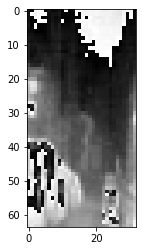

In [15]:
plt.imshow(x_train[13411,:].reshape(64,32),cmap="gray")
plt.show()

In [22]:
num_epochs = 5
num_classes = 2
batch_size = 2
lr = 0.0001

from torch.utils import data
    
train = torch.utils.data.TensorDataset(x_train,y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

test = torch.utils.data.TensorDataset(x_test,y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

# Deep residual network

In [23]:
def conv3x3(in_plane,out_plane,stride=1):
    return nn.Conv2d(in_plane,out_plane,kernel_size=3,stride=stride,padding=1,bias= False)

def conv1x1(in_plane,out_plane,stride=1):
    return nn.Conv2d(in_plane, out_plane, kernel_size=1, stride=stride, bias= False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample= None):
        super(BasicBlock,self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace = True)
        self.drop = nn.Dropout(0.9)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self,x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        
        out = self.relu(out)
        
        return out
    


In [24]:
class ResNet(nn.Module):
    def __init__(self, block, layers:list, num_classes = num_classes):
        super(ResNet,self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1,64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64 ,layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128 ,layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256 ,layers[2], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode="fan_out",nonlinearity="relu")
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
        
    def _make_layer(self, block, planes, blocks, stride = 1):
        downsample = None
        
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes*block.expansion, stride),
                nn.BatchNorm2d(planes*block.expansion))
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes*block.expansion
        
        for _ in range(1,blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        
        return x

In [25]:
model = ResNet(BasicBlock, [2,2,2])

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr =lr)

In [ ]:
loss_list = []
train_acc = []
test_acc = []
use_gpu = False

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images = images.view(batch_size,1,64,32)
        images = images.float()
        
        outputs = model(images)
        
        loss = criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%1000 == 0:
            print("Epoch:=============> {} {}/{}".format(epoch,i,total_step))
            
    correct = 0
    total = 0
    with torch.no_grad:
        for data in train_loader:
            images,labels = data
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct = (predicted==labels).sum().item()
    print("Train accuracy : %d  %%"%(100*correct/total))
    train_acc.append(100*correct/total)
    
    correct = 0
    total = 0
    with torch.no_grad:
        for data in test_loader:
            images,labels = data
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct = (predicted==labels).sum().item()
    print("Test accuracy : %d  %%"%(100*correct/total))
    test_acc.append(100*correct/total)
    loss_list.append(loss.item())
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            

Epoch:=============> 0 0/26799
Epoch:=============> 0 1000/26799
Epoch:=============> 0 2000/26799
